<h1>How to buy best buy apartment in Zagreb</h1>

<h2>1. Introduction/Business Problem</h2>

**1.Introduction**

It is very hard to locate a apartment which will satisfy budget and also social life. For young families its very important so select a districts which will provide high quality infrastructure in form of schools, kinder gartens, public transport. In the same time they don't want to reduce quality of life by reducing access to venues like restaurants, pubs, museums, or other cultural venues.

**1.1 Problem**

In order to save time and money it is required to analyse huge amounts of data and even then eventual decision is due to lack of available information. Properties tend to get more and more expensive which maks decisio to pick a district even harder and more time consuming. Also sellers because they set their price too high might also wait too much to finish sale.

**1.2 Interest**

Understanding features which influence the price can help people who are searching for a property to focus on districts which is  within their budget, in the same time sellers who have their price too high can in this analysis find a reason why this might happen.

<h2>2. DATA COLLECTION</h2>

**2.1 Data sources**

In order to get relevant data for this analysis i had to create geodata.json of city of Zgareb to be able to create cloropleth maps. Some general data about each city district i have scraped from wikipedia, and some data on properties value i have scraped from njuskalo.hr (probably the biggest portal for advertising in Croatia). I will also use data from fousquare.com to analyse number of venues per districts to check if it contributes to the price.

**2.2 Data cleaning**

As i don't use hige datasets to analyse correlation between few parameters, only dataset related to price of the properties had be cleaned. Some vlaues were not present in the datasets and some values were extreme, therefore i have excluded those to have more relevant results.

**2.3 Feature selection**

For this analysis i have decided to use district population, density(inhabitants/sqm),average asset price and number od venues per district

<h2>3. DATA preparing and cleaning</h2>

lets fetch all libraries

In [64]:
from geopy.geocoders import Nominatim
import folium
import numpy as np
import seaborn as sns
import json
import requests
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
import pandas as pd
import bs4
import requests
import lxml
import html5lib
from pandas.io.json import json_normalize
import re
import csv
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

mpl.style.use('ggplot') # optional: for ggplot-like style

lets load all data

In [73]:
Latitude=45.813177
Longitude=15.977048

In [4]:
xl = pd.ExcelFile("Zagreb_districts.xlsx")

In [5]:
df = xl.parse("Sheet1")

In [6]:
df.head(5)

,City quarter,Lat,Lon,size,population,density
0,Trnje,45.797038,15.982495,7,42282.0,12341
1,Donji grad,45.809878,15.977081,3,37024.0,12341
2,Gornji grad Medvescak,45.825974,15.974836,10,30962.0,3096
3,Maksimir,45.833312,16.010151,14,48902.0,3493
4,Pescenica - Zitnjak,45.787527,16.045939,35,56487.0,1614


lets load foursqare data

In [7]:
CLIENT_ID = 'GHHU0AV2RH5UJL1LTLSCN0G2ZCONUY0OSVPMYDFDIEBJBYYG' # your Foursquare ID
CLIENT_SECRET = '1R44PQXYZDOZDGJS3B33VXUDWUFP5HDDN14QWO5R3SC4CBA4' # your Foursquare Secret
VERSION = '20190227' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GHHU0AV2RH5UJL1LTLSCN0G2ZCONUY0OSVPMYDFDIEBJBYYG
CLIENT_SECRET:1R44PQXYZDOZDGJS3B33VXUDWUFP5HDDN14QWO5R3SC4CBA4


borowing some nice functions from course

In [8]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Fetching venues for all zagreb dictricts

In [10]:
zagreb_venues = getNearbyVenues(names=df['City quarter'],
                                   latitudes=df['Lat'],
                                   longitudes=df['Lon']
                                  )

Trnje
Donji grad
Gornji grad Medvescak
Maksimir
Pescenica - Zitnjak
Novi Zagreb - Istok
Novi Zagreb – zapad
Tresnjevka – sjever 
Tresnjevka – jug 
Crnomerec
Gornja Dubrava
Donja Dubrava
Stenjevec
Podsused - Vrapce
Podsljeme
Sesvete
Brezovica


droping duplicates and fixind data so i don't fortget to do it later

In [11]:
zagreb_venues.drop_duplicates(subset=['Venue'],inplace=True)

In [12]:
venues_count=zagreb_venues.groupby('Neighborhood').count()

In [14]:
venues_count=venues_count.reset_index()

In [15]:
df1 = venues_count[['Neighborhood','Venue']]

In [16]:
df1.head(5)

,Neighborhood,Venue
0,Crnomerec,11
1,Donja Dubrava,18
2,Donji grad,80
3,Gornja Dubrava,4
4,Gornji grad Medvescak,59


Reading aparmant data

In [18]:
df_ap=pd.read_csv('oglasi2.csv',encoding='utf-8',header=None,error_bad_lines=False)

In [20]:
df_ap.drop([0], axis=1,inplace=True)

In [21]:
columns=['District','Surface','Price']

df_ap.columns=columns

In [23]:
df_ap=df_ap.dropna()

adding column with average price

In [25]:
df_ap['price_per_sqm']=df_ap['Price']/df_ap['Surface']

In [26]:
df_ap['price_per_sqm']=df_ap['price_per_sqm'].astype('int')

In [27]:
df_ap=df_ap[df_ap['Surface'] > 20]

In [28]:
df_ap.head(5)

,District,Surface,Price,price_per_sqm
2,Donji Grad,28,40999.0,1464
4,Donji Grad,62,102000.0,1645
5,Trešnjevka - Jug,55,135000.0,2454
11,Maksimir,88,157000.0,1784
13,Trešnjevka - Jug,107,160000.0,1495


In [111]:
df_mean=df_ap.groupby('District')['price_per_sqm'].mean()
df_mean=df_mean.to_frame()
df_mean=df_mean.reset_index()

droping some undesired values

In [122]:
df_mean

,District,price_per_sqm
0,Donja Dubrava,1602.555556
1,Donji Grad,2269.315789
2,Gornja Dubrava,1330.421053
3,Gornji Grad - MedveÅ¡Äak,1916.086957
4,Maksimir,1831.581395
5,Novi Zagreb - Istok,1476.666667
6,Novi Zagreb - Zapad,1709.184211
7,PeÅ¡Äenica - Å½itnjak,1628.850000
8,Podsljeme,1722.210526
9,Podsused - VrapÄe,1445.416667


droping Zagreb - Okolica and TreÅ¡njevka - Jug

In [124]:
df_mean=df_mean.drop([16])

renaming to be more consistent across different datasets

In [121]:
df_mean['District'].values

array(['Donja Dubrava', 'Donji Grad', 'Gornja Dubrava',
       'Gornji Grad - MedveÅ¡Ä\x8dak', 'Maksimir', 'Novi Zagreb - Istok',
       'Novi Zagreb - Zapad', 'PeÅ¡Ä\x8denica - Å½itnjak', 'Podsljeme',
       'Podsused - VrapÄ\x8de', 'Sesvete', 'Stenjevec',
       'TreÅ¡njevka - Jug', 'Trešnjevka - Jug', 'Trešnjevka - Sjever',
       'Trnje', 'Zagreb - Okolica', 'ÄŒrnomerec'], dtype=object)

In [36]:
df_mean['District']=['Donja dubrava','Donjigrad', 'Gornja dubrava','Gornji_grad_Medvescak','Maksimir', 'Novi Zagreb - Istok',
       'Novi Zagreb - Zapad','Pescenica - Zitnjak', 'Podsljeme','Podsused - Vrapce', 'Sesvete', 'Stenjevec',
       'Tresnjevkajug', 'Tresnjevkasjever', 'Trnje','Crnomerec']

loading zagreb geo data json

In [37]:
zagreb_geo = r'zagreb_districts.json'

In [110]:
df_mean

,District,price_per_sqm
0,Trnje,1602.555556
1,Donji grad,2269.315789
2,Gornja Dubrava,1330.421053
3,Gornji grad Medvescak,1916.086957
4,Maksimir,1831.581395
5,Novi Zagreb - Istok,1476.666667
6,Novi Zagreb - Zapad,1709.184211
7,Pescenica - Zitnjak,1628.850000
8,Podsljeme,1722.210526
9,Podsused - Vrapce,1445.416667


<h2>4. DATA ANALYSIS</h2>

As i would like to analyse actual situation and accordingly find any anomaly in the market so can find locate district which has the best proportion between the price per square meter and contents like venues, pubs, restaraunts etc.

Firstly i am going to visualise actual map of Zagreb and create cloropleth map with average price on top.

In [39]:
threshold_scale = np.linspace(df_mean['price_per_sqm'].min(),
                              df_mean['price_per_sqm'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1


zagreb_map = folium.Map(location=[45.813177, 15.977048], zoom_start=11)
zagreb_map.choropleth(
    geo_data=zagreb_geo,
    data=df_mean,
    columns=['District', 'price_per_sqm'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average apartmant price per sqm/district',
    reset=True
)
zagreb_map

C:\Anaconda\lib\site-packages\folium\folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Above map is actually as expected, apartment closer to city center on average cost more than those which more distant.
it is worth noticing there 3 districts with lowest average price, of which Novi Zagreb - Istok is very well connected also dubrava is very good connected so form above map i would put some focus on those disctricts.

But said in introduction i would like to check also how well this districts stand regarding to content.

So i will use foursquare data to see how many venues are located per each district.

In [44]:
zagreb_map_with_venues= folium.Map(location=[45.813177, 15.977048], zoom_start=11)
zagreb_map_with_venues.choropleth(
    geo_data=zagreb_geo,
    data=df_mean,
    columns=['District', 'price_per_sqm'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity='0.5',
    
)
for lat, lng, neighborhood in zip(zagreb_venues['Venue Latitude'], zagreb_venues['Venue Longitude'], zagreb_venues['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=0.6,
        #popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(zagreb_map_with_venues) 
zagreb_map_with_venues

C:\Anaconda\lib\site-packages\folium\folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Inspecting above map now with venues on top of map with apartments average prices i can again confirm that those districts which are the most expensive have also more content than thos which are cheaper.

lets try to analyse each neighborhood

In [47]:
# one hot encoding
zagreb_onehot = pd.get_dummies(zagreb_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
zagreb_onehot['Neighborhood'] = zagreb_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [zagreb_onehot.columns[-1]] + list(zagreb_onehot.columns[:-1])
zagreb_onehot = zagreb_onehot[fixed_columns]

zagreb_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,...,Supermarket,Tennis Stadium,Theater,Track,Trail,Train Station,Turkish Restaurant,Volleyball Court,Water Park,Wine Bar
0,Trnje,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Trnje,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Trnje,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Trnje,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Trnje,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
zagreb_grouped = zagreb_onehot.groupby('Neighborhood').mean().reset_index()
zagreb_grouped

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,...,Supermarket,Tennis Stadium,Theater,Track,Trail,Train Station,Turkish Restaurant,Volleyball Court,Water Park,Wine Bar
0,Crnomerec,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,...,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Donja Dubrava,0.0000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.055556,...,0.055556,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000
2,Donji grad,0.0125,0.000000,0.000000,0.000000,0.012500,0.000000,0.012500,0.000000,0.000000,...,0.000000,0.000000,0.037500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000
3,Gornja Dubrava,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Gornji grad Medvescak,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.016949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033898
5,Maksimir,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.107143,0.000000,0.000000,...,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Novi Zagreb - Istok,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,...,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Novi Zagreb – zapad,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Pescenica - Zitnjak,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Podsljeme,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000


In [50]:
num_top_venues = 5

for hood in zagreb_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = zagreb_grouped[zagreb_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Crnomerec----
         venue  freq
0         Café  0.36
1    BBQ Joint  0.18
2  Supermarket  0.09
3       Bistro  0.09
4     Sake Bar  0.09


----Donja Dubrava----
                    venue  freq
0      Light Rail Station  0.28
1    Gym / Fitness Center  0.06
2             Supermarket  0.06
3  Furniture / Home Store  0.06
4              Shoe Store  0.06


----Donji grad----
          venue  freq
0          Café  0.09
1  Dessert Shop  0.08
2        Bistro  0.06
3         Plaza  0.05
4        Hostel  0.05


----Gornja Dubrava----
                       venue  freq
0                        Bar  0.25
1                       Park  0.25
2  Middle Eastern Restaurant  0.25
3               Soccer Field  0.25
4                   Pharmacy  0.00


----Gornji grad Medvescak----
                      venue  freq
0                       Bar  0.12
1  Mediterranean Restaurant  0.08
2             Historic Site  0.07
3                      Park  0.05
4                       Pub  0.05


----Maksimir--

From above results it seems like all neghboorhoods in Croatia are similar as only venue which is top in each district is Cafe bar. :S

lets prepare data for k-means clustering

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [56]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zagreb_venues_sorted = pd.DataFrame(columns=columns)
zagreb_venues_sorted['Neighborhood'] = zagreb_grouped['Neighborhood']

for ind in np.arange(zagreb_grouped.shape[0]):
    zagreb_venues_sorted.iloc[ind, 1:] = return_most_common_venues(zagreb_grouped.iloc[ind, :], num_top_venues)

zagreb_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Crnomerec,Café,BBQ Joint,Bistro,Park,Mediterranean Restaurant,Supermarket,Sake Bar,Wine Bar,Flea Market,Field
1,Donja Dubrava,Light Rail Station,Pizza Place,Bakery,Clothing Store,Café,Bus Station,Shoe Store,Snack Place,Bar,Furniture / Home Store
2,Donji grad,Café,Dessert Shop,Bistro,Wine Bar,Hostel,Plaza,Bar,Scenic Lookout,Coffee Shop,Mediterranean Restaurant
3,Gornja Dubrava,Bar,Soccer Field,Middle Eastern Restaurant,Park,Wine Bar,Flea Market,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant
4,Gornji grad Medvescak,Bar,Mediterranean Restaurant,Historic Site,Dessert Shop,Park,Pub,Movie Theater,Eastern European Restaurant,Pizza Place,Restaurant


In [58]:
# set number of clusters
kclusters = 5

zagreb_grouped_clustering = zagreb_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(zagreb_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 4, 1, 3, 1, 1, 1, 2, 4, 0])

In [68]:
# add clustering labels
#zagreb_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

zagreb_merged = zagreb_venues

zagreb_merged = zagreb_merged.join(zagreb_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

zagreb_merged.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Trnje,45.797038,15.982495,Koncertna dvorana Vatroslava Lisinskog,45.800668,15.979983,Concert Hall,1,Café,Bar,Restaurant,Hotel,Pizza Place,Plaza,Bakery,Nightclub,BBQ Joint,Music Venue
1,Trnje,45.797038,15.982495,Vivas Bar,45.798404,15.987945,Café,1,Café,Bar,Restaurant,Hotel,Pizza Place,Plaza,Bakery,Nightclub,BBQ Joint,Music Venue
2,Trnje,45.797038,15.982495,Route 66,45.798669,15.977747,Bar,1,Café,Bar,Restaurant,Hotel,Pizza Place,Plaza,Bakery,Nightclub,BBQ Joint,Music Venue
3,Trnje,45.797038,15.982495,Batak grill,45.794453,15.992611,BBQ Joint,1,Café,Bar,Restaurant,Hotel,Pizza Place,Plaza,Bakery,Nightclub,BBQ Joint,Music Venue
4,Trnje,45.797038,15.982495,Esplanade Zagreb *****,45.805540,15.976059,Hotel,1,Café,Bar,Restaurant,Hotel,Pizza Place,Plaza,Bakery,Nightclub,BBQ Joint,Music Venue


In [77]:
map_clusters = folium.Map(location=[Latitude, Longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(zagreb_merged['Venue Latitude'], zagreb_merged['Venue Longitude'], zagreb_merged['Neighborhood'], zagreb_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

K-means clustering has helped here only to differentiate between major locations. So options are Zagreb center, Dubrava, Sesvete or top mountain Sljeme. So this ML technique i think is not so much esefull here. So i don't see any need to analyse any further.

Beside of the above findings i would like also to check if there is some correlation between population, density, average price, and size of the disctrict.

In [92]:
df

,District,Lat,Lon,size,population,density
0,Trnje,45.797038,15.982495,7,42282.000,12341
1,Donji grad,45.809878,15.977081,3,37024.000,12341
2,Gornji grad Medvescak,45.825974,15.974836,10,30962.000,3096
3,Maksimir,45.833312,16.010151,14,48902.000,3493
4,Pescenica - Zitnjak,45.787527,16.045939,35,56487.000,1614
5,Novi Zagreb - Istok,45.759520,16.007969,17,59055.000,3474
6,Novi Zagreb – zapad,45.760738,15.921552,63,58103.000,922
7,Tresnjevka – sjever,45.801677,15.940319,6,55425.000,9238
8,Tresnjevka – jug,45.786266,15.922941,10,6.674,6667
9,Crnomerec,45.827382,15.933554,24,38546.000,1606


In [91]:
df=df.rename(columns = {"City quarter": "District"})

In [100]:
df['District'].values

array(['Trnje', 'Donji grad', 'Gornji grad Medvescak', 'Maksimir',
       'Pescenica - Zitnjak', 'Novi Zagreb - Istok',
       'Novi Zagreb – zapad', 'Tresnjevka – sjever\xa0',
       'Tresnjevka – jug\xa0', 'Crnomerec', 'Gornja Dubrava',
       'Donja Dubrava', 'Stenjevec', 'Podsused - Vrapce', 'Podsljeme',
       'Sesvete', 'Brezovica'], dtype=object)

In [125]:
df_mean['District']=['Donja Dubrava','Donji grad', 'Gornja Dubrava','Gornji grad Medvescak','Maksimir', 'Novi Zagreb - Istok',
       'Novi Zagreb - Zapad','Pescenica - Zitnjak', 'Podsljeme','Podsused - Vrapce', 'Sesvete', 'Stenjevec',
       'Tresnjevka - jug', 'Tresnjevka - sjever','Trnje','Crnomerec']

In [126]:
df_mean['District'].values

array(['Donja Dubrava', 'Donji grad', 'Gornja Dubrava',
       'Gornji grad Medvescak', 'Maksimir', 'Novi Zagreb - Istok',
       'Novi Zagreb - Zapad', 'Pescenica - Zitnjak', 'Podsljeme',
       'Podsused - Vrapce', 'Sesvete', 'Stenjevec', 'Tresnjevka - jug',
       'Tresnjevka - sjever', 'Trnje', 'Crnomerec'], dtype=object)

now i have 3 datasets alligned, so lets merged them and analyse again

In [127]:
df_tot=pd.merge(df1, df, on="District")

In [129]:
df_tot=pd.merge(df_mean, df_tot, on="District")

In [130]:
df_tot

,District,price_per_sqm,Venue,Lat,Lon,size,population,density
0,Donja Dubrava,1602.555556,18,45.816409,16.069855,11,36363.0,3306
1,Donji grad,2269.315789,80,45.809878,15.977081,3,37024.0,12341
2,Gornja Dubrava,1330.421053,4,45.864777,16.056851,40,61841.0,1546
3,Gornji grad Medvescak,1916.086957,59,45.825974,15.974836,10,30962.0,3096
4,Maksimir,1831.581395,28,45.833312,16.010151,14,48902.0,3493
5,Novi Zagreb - Istok,1476.666667,11,45.759520,16.007969,17,59055.0,3474
6,Pescenica - Zitnjak,1628.850000,13,45.787527,16.045939,35,56487.0,1614
7,Podsljeme,1722.210526,6,45.888748,15.984549,60,19165.0,319
8,Podsused - Vrapce,1445.416667,5,45.834528,15.868742,36,45759.0,1271
9,Sesvete,1619.222222,18,45.828537,16.110122,165,70009.0,424


now i have single datasets which combines foursquare data, wikipedia data and njuskalo data. Lets check if any correlation

In [133]:
df_tot.corr()

,price_per_sqm,Venue,Lat,Lon,size,population,density
price_per_sqm,1.000000,0.731507,-0.094508,-0.193930,-0.309831,-0.335301,0.663027
Venue,0.731507,1.000000,-0.309355,-0.138885,-0.371247,-0.252046,0.907150
Lat,-0.094508,-0.309355,1.000000,0.031084,0.305993,-0.158676,-0.398806
Lon,-0.193930,-0.138885,0.031084,1.000000,0.476723,0.640320,-0.146984
size,-0.309831,-0.371247,0.305993,0.476723,1.000000,0.457096,-0.486604
population,-0.335301,-0.252046,-0.158676,0.640320,0.457096,1.000000,-0.173559
density,0.663027,0.907150,-0.398806,-0.146984,-0.486604,-0.173559,1.000000


By observing above correlation chart i can notice that closest correlation is on number of venues if district heavily populated. Also number of venues is correlated to price per square meter.

In [134]:
df_sqm=df_tot[['District','price_per_sqm']]

In [137]:
df_sqm=df_sqm.set_index('District')

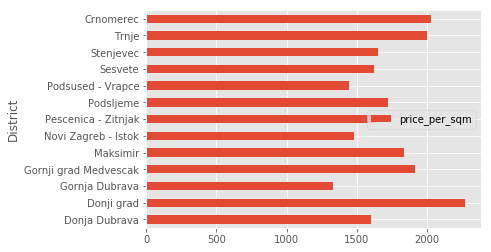

In [138]:
df_sqm.plot.barh(rot=0)

so now i can check how each districts stands as per price per square meter

lets check how compares price_per_sqm vs venue count

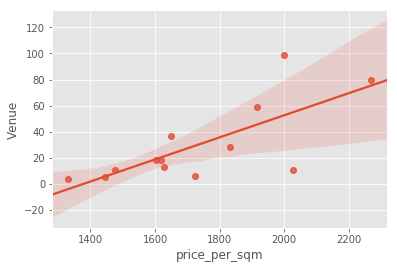

In [142]:
sns.regplot(x="price_per_sqm", y="Venue", data=df_tot)

now is a lot easier to notice how as number of venue is bigger also price is higher

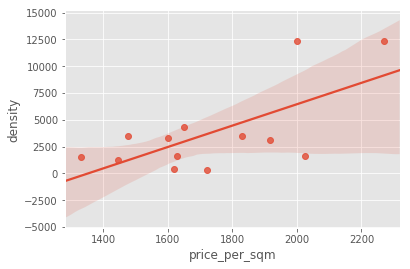

In [143]:
sns.regplot(x="price_per_sqm", y="density", data=df_tot)

if i check density(population/district size) it can be concluded that as area is more densely populated price is growing.

<h2>5. Discussion</h2>

Above findings are quite interesting and people are very much interested into data which might help them to locate apartmants which are within their budget while also attractive. My sample is too small to be of any significance but still it can present how much is different each district.

It would great if in some future project i could check on more granular level how each city neighborhood relates to other to perhaps notice some anomaly and use this data to find faster appropriate real estate. 

I took only few datasets and mostly i have created them alone so i couldn't guess what would be result but still looks interesting. Perhaps some more datasets related to schools, offices, public transport might also help to dive deeper into understanding what is driving eal estate's price so high, or what is degrading its value.

<h2>6. Conclusion</h2>

Its almost impossibile to find "best buy" appartmant as people differ by huge margins. So some people who have bigger budget won't try to get lower price, while some might not even be able to get anything.
From above findings i can conclude that best buy apartmant is definitely either in Novi Zagreb - istok or Gornja dubrava. Both district are in tram area which is very much important as tram travel quite often in zagreb. Both districts have quite low average price per square meter so there is greater chance to get higher quality real estate while not compromising easy access to city content and events.